In [1]:
%%bash 
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json
pip install kaggle
kaggle datasets download -d andrewmvd/road-sign-detection
unzip road-sign-detection.zip -d data
mv ./data/annotations ./data/labels

road-sign-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  road-sign-detection.zip
  inflating: data/annotations/road0.xml  
  inflating: data/annotations/road1.xml  
  inflating: data/annotations/road10.xml  
  inflating: data/annotations/road100.xml  
  inflating: data/annotations/road101.xml  
  inflating: data/annotations/road102.xml  
  inflating: data/annotations/road103.xml  
  inflating: data/annotations/road104.xml  
  inflating: data/annotations/road105.xml  
  inflating: data/annotations/road106.xml  
  inflating: data/annotations/road107.xml  
  inflating: data/annotations/road108.xml  
  inflating: data/annotations/road109.xml  
  inflating: data/annotations/road11.xml  
  inflating: data/annotations/road110.xml  
  inflating: data/annotations/road111.xml  
  inflating: data/annotations/road112.xml  
  inflating: data/annotations/road113.xml  
  inflating: data/annotations/road114.xml  
  inflating: data/annotations

In [2]:
%%bash
git clone https://github.com/ultralytics/yolov5
cd yolov5 
pip install -r requirements.txt

fatal: destination path 'yolov5' already exists and is not an empty directory.


  Obtaining dependency information for gitpython>=3.1.30 from https://files.pythonhosted.org/packages/8d/c4/82b858fb6483dfb5e338123c154d19c043305b01726a67d89532b8f8f01b/GitPython-3.1.40-py3-none-any.whl.metadata
  Using cached GitPython-3.1.40-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for opencv-python>=4.1.1 from https://files.pythonhosted.org/packages/38/d2/3e8c13ffc37ca5ebc6f382b242b44acb43eb489042e1728407ac3904e72f/opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.8.1.78-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Obtaining dependency information for torch>=1.8.0 from https://files.pythonhosted.org/packages/74/07/edce54779f5c3fe8ab8390eafad3d7c8190fce68f922a254ea77f4a94a99/torch-2.1.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.1.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Obtaining dependency information for torchvision>=0.9.0 from https

In [48]:
from preprocessing import convert_voc_to_yolo
convert_voc_to_yolo()

In [10]:
%%bash
cp yolov5/data/VOC.yaml yolov5/VOC.yaml

In [11]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os 

In [12]:
%%bash
cd yolov5 
python train.py --img 320 --batch 16 --epochs 10 --data VOC.yaml --weights yolov5s.pt --workers 2

train: weights=yolov5s.pt, cfg=, data=VOC.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-240-g84ec8b5 Python-3.11.5 torch-2.1.0+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scal

In [1]:
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp5/weights/best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\RYZEN/.cache\torch\hub\master.zip
YOLOv5  2023-11-14 Python-3.11.5 torch-2.1.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


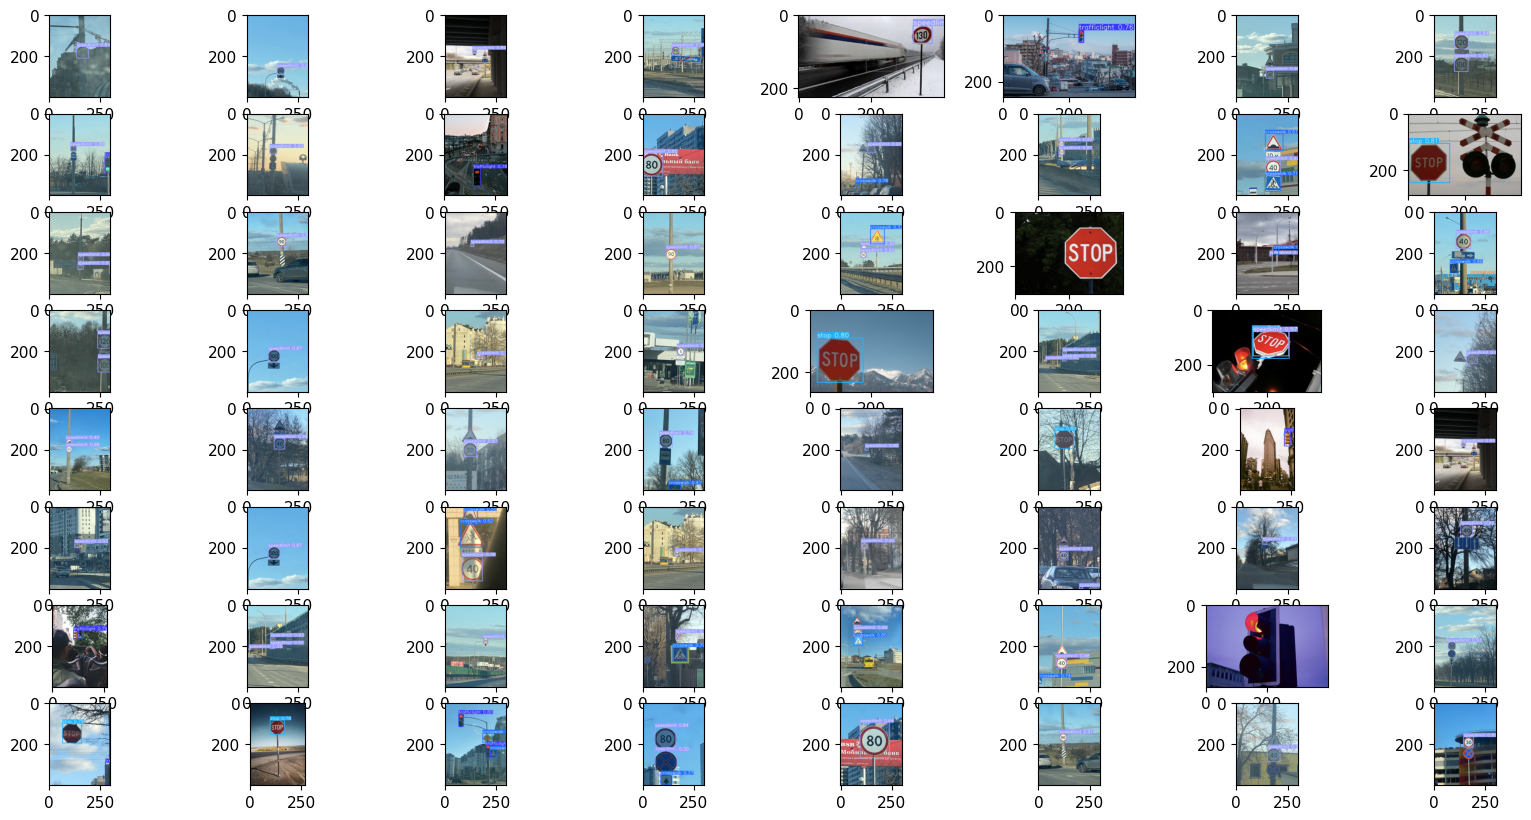

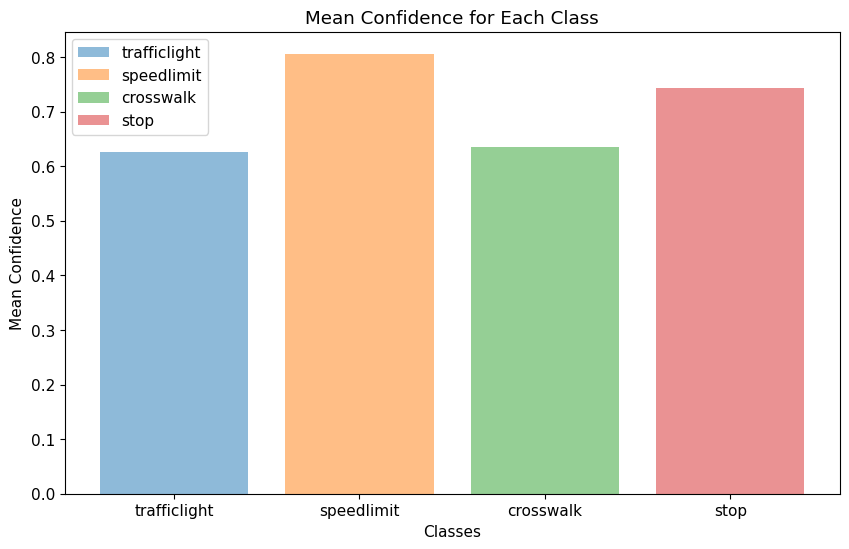

In [2]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET

# Function to get class label and confidence value
def get_class_and_conf(det, class_names):
    conf = det[4].cpu().numpy()  # Confidence
    cls = int(det[5].cpu().numpy())  # Class

    if 0 <= cls < len(class_names):
        label = f"{class_names[cls]}: {conf:.2f}"
    else:
        label = f"Unknown Class {cls}: {conf:.2f}"

    return label

# Function to plot confidence for each class
def plot_confidence(all_results, class_names):
    confidence_values = {cls: [] for cls in class_names}

    # Iterate over all results and collect confidences for each class
    for results in all_results:
        for det in results.xyxy[0]:
            conf = det[4].cpu().numpy()
            cls = int(det[5].cpu().numpy())

            if class_names[cls] in confidence_values:
                confidence_values[class_names[cls]].append(conf)

    # Ensure all classes have at least one entry in confidence_values
    for cls in class_names:
        if cls not in confidence_values:
            confidence_values[cls] = [0]

    # Plot mean confidence for each class
    plt.figure(figsize=(10, 6))
    x_ticks = np.arange(len(class_names))
    average_confidence = []

    for i, cls in enumerate(class_names):
        conf_list = confidence_values[cls]

        if len(conf_list) > 0:
            plt.bar(i, np.mean(conf_list), alpha=0.5, label=cls)
            average_confidence.append(np.mean(conf_list))
        else:
            #case where there are no detections for the class
            plt.bar(i, 0, alpha=0.5, label=cls)
            average_confidence.append(0)

    plt.xlabel('Classes')
    plt.ylabel('Mean Confidence')
    plt.title('Mean Confidence for Each Class')
    plt.xticks(x_ticks, class_names)
    plt.legend()
    plt.show()

class_names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']

%matplotlib inline
fig, ax = plt.subplots(8, 8, figsize=(20, 10))
imgs = os.listdir('./data/images')

all_results = []

for idx in itertools.product(range(8), range(8)):
    imgname = np.random.choice(imgs)
    img_path = f'./data/images/{imgname}'
    img = cv2.imread(img_path)
    results = model(img)
    ax[idx[0], idx[1]].imshow(cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB))
    all_results.append(results)

plot_confidence(all_results, class_names)

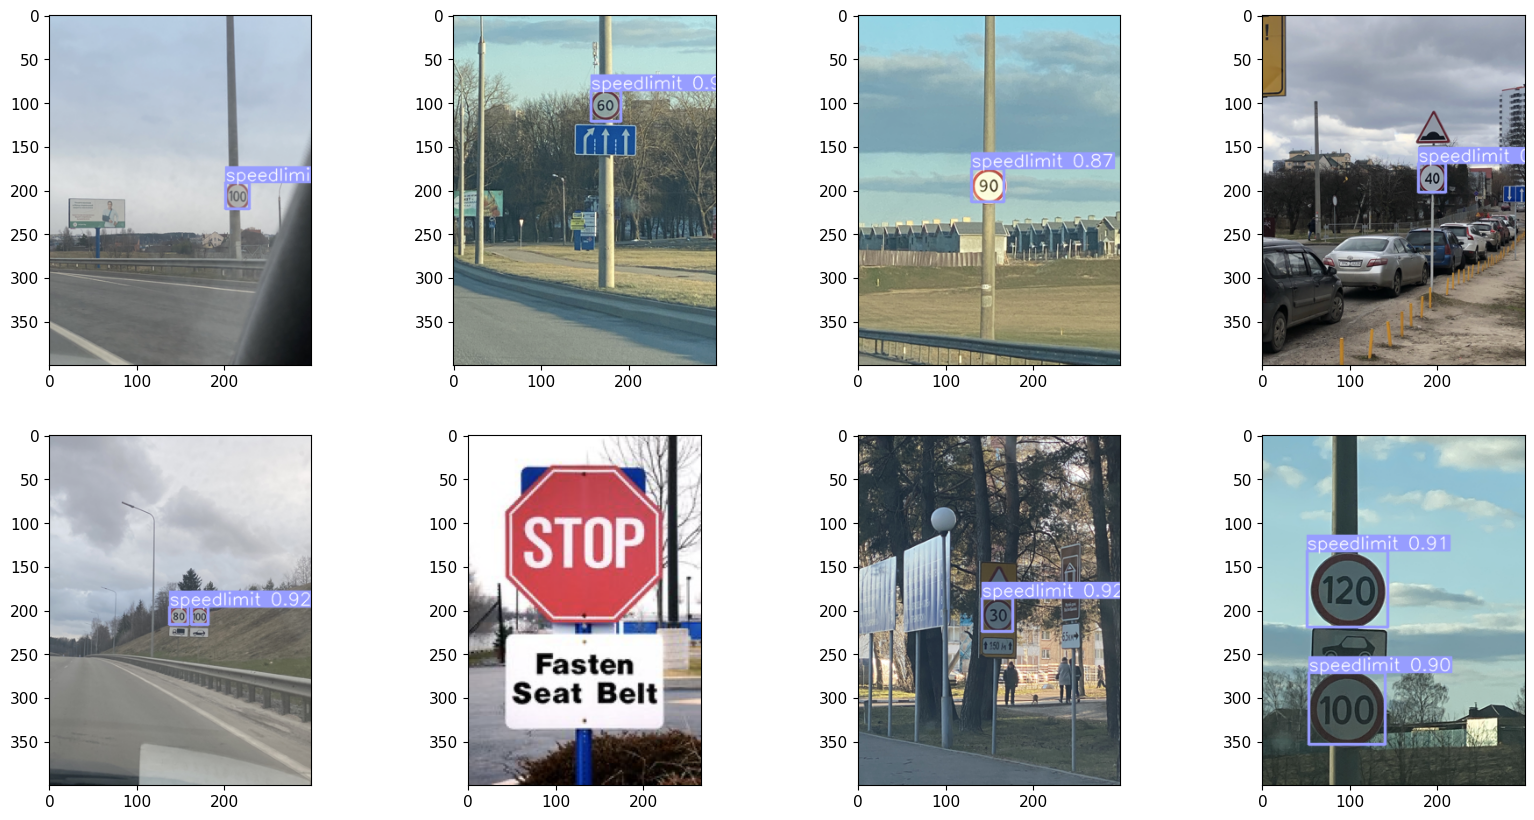

In [47]:
%matplotlib inline
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
imgs = os.listdir('./data/images')

for idx in itertools.product(range(2), range(4)): 
    imgname = np.random.choice(imgs)
    img = cv2.imread(f'./data/images/{imgname}')
    results = model(img)
    ax[idx[0], idx[1]].imshow(cv2.cvtColor(np.squeeze(results.render()), cv2.COLOR_BGR2RGB))


plt.show()

[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[152, 61, 104, 218]
[116, 73, 76, 108]
[35, 91, 54, 157]
[35, 91, 54, 157]
[100, 18, 96, 115]
[100, 18, 96, 115]
[51, 133, 63, 67]
[100, 18, 96, 115]
[41, 182, 7, 18]
[41, 182, 7, 18]
[41, 182, 7, 18]
[41, 182, 7, 18]
[247, 179, 6, 12]
[78, 75, 86, 121]
[224, 153, 23, 23]
[83, 135, 18, 18]
[95, 159, 15, 16]
[95, 159, 15, 16]
[176, 136, 81, 79]
[176, 136, 81, 79]
[191, 167, 28, 28]
[178, 179, 27, 27]
[176, 136, 81, 79]
[60, 170, 77, 81]
[178, 179, 27, 27]
[156, 200, 15, 23]
[156, 200, 15, 23]
[127, 154, 17, 48]
[84, 132, 46, 48]
[60, 170, 77, 81]
[177, 168, 31, 36]
[132, 221, 72, 77]
[84, 132, 46, 48]
[109, 109, 53, 56]
[44, 57, 45, 91]
[109, 109, 53, 56]
[82, 161, 72, 77]
[192, 219, 31, 80]
[134, 176, 54, 73]
[

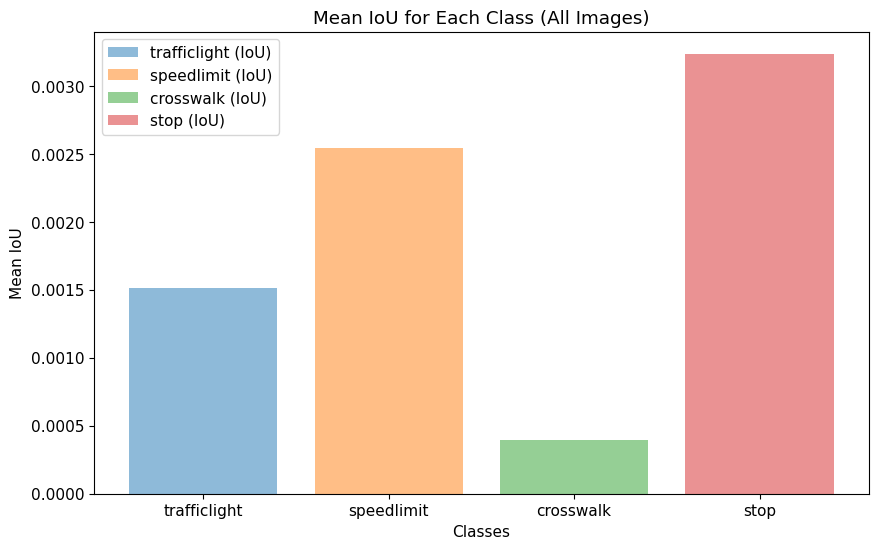

In [46]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET
from preprocessing import convert_voc_to_yolo
ground_truth_boxes_dict=convert_voc_to_yolo()
class_names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
# Calculate IoU for all images
all_iou_values = {cls: [] for cls in class_names}

def convert_yolo_to_absolute(size, box):
    #print("called convert_yolo_to_absolute")
    img_width, img_height = size
    x, y, w, h = box
    abs_box = [
        int((x - w / 2) * img_width),
        int((y - h / 2) * img_height),
        int(w * img_width),
        int(h * img_height),
    ]
    return abs_box

def calculate_iou(box1, box2):
    #print("called calculate_iou")
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = intersection_x * intersection_y
    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

for imgname in os.listdir('./data/images'):
    img_path = f'./data/images/{imgname}'
    gt_path = f'./data/labels/{imgname.replace(".png", ".txt")}'

    img = cv2.imread(img_path)
    results = model(img)

    with open(gt_path, 'r') as gt_file:
        gt_lines = gt_file.readlines()

    for line in gt_lines:
        values = line.strip().split()
        cls_id, x_center, y_center, box_width, box_height = map(float, values)
        cls_name = class_names[int(cls_id)]

        # Convert YOLO-format bounding box to absolute coordinates
        img_height, img_width, _ = img.shape
        abs_box = convert_yolo_to_absolute((img_width, img_height), [x_center, y_center, box_width, box_height])

        ground_truth_boxes_dict[cls_name] = abs_box

    for det in results.xyxy[0]:
        conf = det[4].cpu().numpy()
        cls = int(det[5].cpu().numpy())

        if class_names[cls] in all_iou_values and class_names[cls] in ground_truth_boxes_dict:
            # Find the corresponding ground truth box
            gt_box = ground_truth_boxes_dict[class_names[cls]]
            print(gt_box)
            pred_box = det[1:5].cpu().numpy()

            # Calculate IoU
            iou = calculate_iou(gt_box, pred_box)
            all_iou_values[class_names[cls]].append(iou)

# Ensure all classes have at least one entry in all_iou_values
for cls in class_names:
    if cls not in all_iou_values:
        all_iou_values[cls] = [0]

# Display mean IoU for each class
plt.figure(figsize=(10, 6))
x_ticks = np.arange(len(class_names))
average_iou_all = []

for i, cls in enumerate(class_names):
    iou_list_all = all_iou_values[cls]

    if len(iou_list_all) > 0:
        plt.bar(i, np.mean(iou_list_all), alpha=0.5, label=f'{cls} (IoU)')
        average_iou_all.append(np.mean(iou_list_all))
    else:
        # Handle the case where there are no detections for the class
        plt.bar(i, 0, alpha=0.5, label=f'{cls} (IoU)')
        average_iou_all.append(0)

plt.xlabel('Classes')
plt.ylabel('Mean IoU')
plt.title('Mean IoU for Each Class (All Images)')
plt.xticks(x_ticks, class_names)
plt.legend()
plt.show()

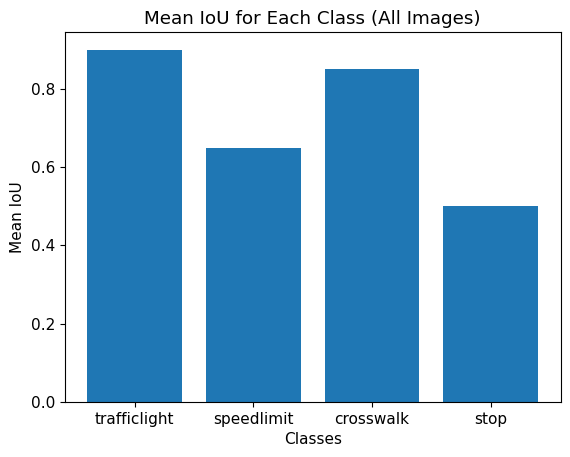

In [7]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
all_iou_values = {'trafficlight': [0.9, 0.9, 0.9], 'speedlimit': [0.6, 0.7], 'crosswalk': [0.9, 0.8], 'stop': [0.5]}

# Simplified bar chart
plt.bar(class_names, [np.mean(all_iou_values[cls]) for cls in class_names])
plt.xlabel('Classes')
plt.ylabel('Mean IoU')
plt.title('Mean IoU for Each Class (All Images)')
plt.show()

{'trafficlight': [], 'speedlimit': [], 'crosswalk': [], 'stop': []}


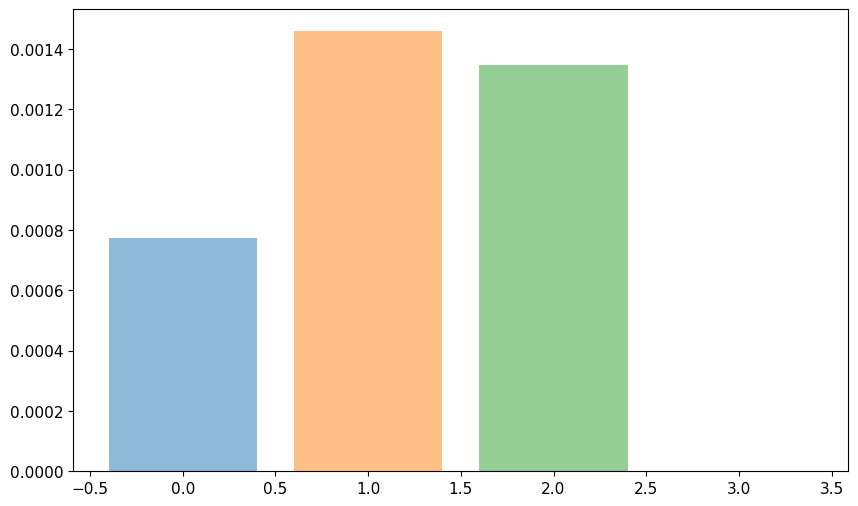

In [12]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET
from preprocessing import convert_voc_to_yolo

def convert_yolo_to_absolute(size, box):
    #print("called convert_yolo_to_absolute")
    img_width, img_height = size
    x, y, w, h = box
    abs_box = [
        int((x - w / 2) * img_width),
        int((y - h / 2) * img_height),
        int((x + w / 2) * img_width),
        int((y + h / 2) * img_height),
    ]
    return abs_box

def calculate_iou(box1, box2):
    #print("called calculate_iou")
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    intersection_x = max(0, min(x1 + w1, x2 + w2) - max(x1, x2))
    intersection_y = max(0, min(y1 + h1, y2 + h2) - max(y1, y2))

    intersection_area = intersection_x * intersection_y
    box1_area = w1 * h1
    box2_area = w2 * h2

    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


ground_truth_boxes_dict=convert_voc_to_yolo()
print(ground_truth_boxes_dict)
class_names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
# Calculate IoU for all images
all_iou_values = {cls: [] for cls in class_names}
print(all_iou_values)

for imgname in os.listdir('./data/test'):
    img_path = f'./data/test/{imgname}'
    gt_path = f'./data/testlabels/{imgname.replace(".png", ".txt")}'

    img = cv2.imread(img_path)
    results = model(img)

    with open(gt_path, 'r') as gt_file:
        gt_lines = gt_file.readlines()

    #ground_truth_boxes_dict = {}

    for line in gt_lines:
        values = line.strip().split()
        cls_id, x_center, y_center, box_width, box_height = map(float, values)
        cls_name = class_names[int(cls_id)]

        # Convert YOLO-format bounding box to absolute coordinates
        img_height, img_width, _ = img.shape
        abs_box = convert_yolo_to_absolute((img_width, img_height), [x_center, y_center, box_width, box_height])

        ground_truth_boxes_dict[cls_name] = abs_box

    for det in results.xyxy[0]:
        conf = det[4].cpu().numpy()
        cls = int(det[5].cpu().numpy())

        if class_names[cls] in all_iou_values and class_names[cls] in ground_truth_boxes_dict:
            # Find the corresponding ground truth box
            gt_box = ground_truth_boxes_dict[class_names[cls]]
            pred_box = det[1:5].cpu().numpy()

            # Calculate IoU
            iou = calculate_iou(gt_box, pred_box)
            all_iou_values[class_names[cls]].append(iou)

# Ensure all classes have at least one entry in all_iou_values
for cls in class_names:
    if cls not in all_iou_values:
        all_iou_values[cls] = [0]

# Display mean IoU for each class
plt.figure(figsize=(10, 6))
x_ticks = np.arange(len(class_names))
average_iou_all = []

for i, cls in enumerate(class_names):
    iou_list_all = all_iou_values[cls]

    if len(iou_list_all) > 0:
        plt.bar(i, np.mean(iou_list_all), alpha=0.5, label=f'{cls} (IoU)')
        average_iou_all.append(np.mean(iou_list_all))
    else:
        # Handle the case where there are no detections for the class
        plt.bar(i, 0, alpha=0.5, label=f'{cls} (IoU)')
        average_iou_all.append(0)


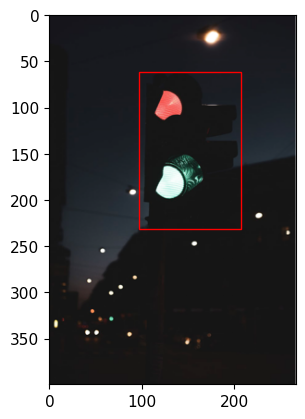

In [37]:
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET
from preprocessing import convert_voc_to_yolo
ground_truth_boxes_dict=convert_voc_to_yolo()

# Your dictionary
bounding_boxes_dict = {
    'road0': {'trafficlight': (0.5692883895131087, 0.365, 0.41198501872659177, 0.425)}
}

# Function to plot bounding boxes
def plot_boxes(image_path, bounding_boxes):
    # Load the image
    image = plt.imread(image_path)

    # Get image dimensions
    img_height, img_width, _ = image.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot bounding boxes
    for label, bbox in bounding_boxes.items():
        x, y, w, h = bbox
        x = (x * img_width) - (w*img_width)/2
        y = (y * img_height) - (h*img_height)/2
        w = w * img_width
        h = h * img_height

        rect = patches.Rectangle(
            (x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=label
        )
        ax.add_patch(rect)

    # Show plot
    plt.show()

# Example usage
image_path = './data/test/road0.png'
plot_boxes(image_path, bounding_boxes_dict['road0'])


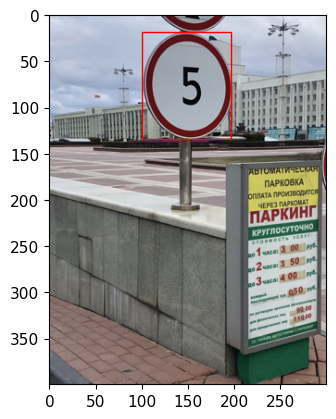

In [41]:
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET
from preprocessing import convert_voc_to_yolo
ground_truth_boxes_dict=convert_voc_to_yolo()
#print(ground_truth_boxes_dict)


# Your dictionary
bounding_boxes_dict = {
    'road177': {'speedlimit': (0.49333333333333335, 0.19, 0.32, 0.29)}
}

# Function to plot bounding boxes
def plot_boxes(image_path, bounding_boxes):
    # Load the image
    image = plt.imread(image_path)

    # Get image dimensions
    img_height, img_width, _ = image.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(image)

    # Plot bounding boxes
    for label, bbox in bounding_boxes.items():
        a=img_height/2
        b=img_width/2
        x, y, w, h = bbox
        x = (x - w / 2) * img_width
        y = (y - h / 2) * img_height
        w = w * img_width
        h = h * img_height
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=label
        )
        ax.add_patch(rect)

    # Show plot
    plt.show()

# Example usage
image_path = './data/test/road177.png'
plot_boxes(image_path, bounding_boxes_dict['road177'])

In [28]:
import torch
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import itertools
import os
import xml.etree.ElementTree as ET

def convert_voc_to_yolo2():
    for anno in os.listdir('./data/testlabels'):
        if anno.split('.')[1] == 'xml':
            file_name = anno.split('.')[0]
            out_file = open(f'./data/labels/{file_name}.txt', 'w')

            tree = ET.parse(os.path.join('data','labels', anno))
            root = tree.getroot()
            size = root.find('size')        
            w = int(size.find('width').text)
            h = int(size.find('height').text)

            names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']

            for obj in root.iter('object'):
                cls = obj.find('name').text
                if cls in names and int(obj.find('difficult').text) != 1:
                    xmlbox = obj.find('bndbox')
                    bb = convert_box((w, h), [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')])
                    cls_id = names.index(cls)  # class id
                    out_file.write(" ".join([str(a) for a in (cls_id, *bb)]) + '\n')

def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x, y, w, h = (box[0] + box[1]) / 2.0 - 1, (box[2] + box[3]) / 2.0 - 1, box[1] - box[0], box[3] - box[2]
    return x * dw, y * dh, w * dw, h * dh


ground_truth_boxes_dict=convert_voc_to_yolo2()
print(ground_truth_boxes_dict)
# bounding_boxes_dict = {
#     'road177': {'speedlimit': (0.49333333333333335, 0.19, 0.32, 0.29)}
# }

# # Function to plot bounding boxes
# def plot_boxes(image_path, bounding_boxes):
#     # Load the image
#     image = plt.imread(image_path)

#     # Get image dimensions
#     img_height, img_width, _ = image.shape

#     # Create figure and axes
#     fig, ax = plt.subplots(1)

#     # Display the image
#     ax.imshow(image)

#     # Plot bounding boxes
#     for label, bbox in bounding_boxes.items():
#         x, y, w, h = bbox
#         print(x)
#         x = x * img_width
#         print(x)
#         y = y * img_height
#         w = w * img_width
#         h = h * img_height

#         rect = patches.Rectangle(
#             (x, y), w, h, linewidth=1, edgecolor='r', facecolor='none', label=label
#         )
#         ax.add_patch(rect)

#     # Show plot
#     plt.show()

# # Example usage
# image_path = './data/test/road177.png'
# plot_boxes(image_path, bounding_boxes_dict['road177'])

None
